In [1]:
import pandas as pd
import numpy as np

import pandas as pd # library for data analsysis

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values



import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#import silhouette score
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# install Beautiful Soup
! pip install beautifulsoup4
! pip install lxml
! pip install request
from bs4 import BeautifulSoup as BS
import requests as r

#import ibm_db
import ibm_db

%load_ext sql
%sql ibm_db_sa://lkm32347:slsbl0d-7twk8mp9@dashdb-txn-sbox-yp-dal09-03.services.dal.bluemix.net:50000/BLUDB
            
!conda install -c districtdatalabs yellowbrick --yes
print('Libraries imported.')

res = r.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BS(res.content,'lxml')
table = soup.find_all('table')[0]
n_list = pd.read_html(str(table))
n_list=n_list[0]
n_list.head()

n_list.set_index('Borough', inplace = True)
n_list.drop("Not assigned",axis=0, inplace = True)
n_list.reset_index(inplace=True)
n_list.set_index('Postcode', inplace = True)
n_list.reset_index(inplace=True)
n_list.head()

n_list.sort_values("Postcode", ascending = True, inplace = True)
toronto_df=n_list.set_index('Postcode').groupby(level=['Postcode'],sort=False).agg(','.join)
toronto_df=toronto_df.reset_index()
n_dictionary=n_list[['Postcode','Borough']].set_index('Postcode').to_dict()
toronto_df['Borough'] = toronto_df.Postcode.map(n_dictionary['Borough'])
toronto_df.head()

toronto_df[toronto_df.Neighbourhood=='Not assigned']

# because it's only one, we can complete this by simply replacing the value manually
toronto_df['Neighbourhood']=toronto_df.Neighbourhood.str.replace("Not assigned", "Queen's Park")

# We can check this record using its index (85)
toronto_df.iloc[[85]]

print("The number of rows in this dataframe is",toronto_df.shape[0])

url = 'http://cocl.us/Geospatial_data'
geodata = pd.read_csv(url)
geodata.head()

geodata.rename(columns={'Postal Code': 'Postcode'},inplace=True)
geodata.head()

geolat_dictionary=geodata[['Postcode','Latitude']].set_index('Postcode').to_dict()
geolat_dictionary=geolat_dictionary['Latitude']
geolong_dictionary=geodata[['Postcode','Longitude']].set_index('Postcode').to_dict()
geolong_dictionary=geolong_dictionary['Longitude']
toronto_df['Latitude'] = toronto_df.Postcode.map(geolat_dictionary)
toronto_df['Longitude'] = toronto_df.Postcode.map(geolong_dictionary)

toronto_df

!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

neighbourhoods_data = newyork_data['features']
neighbourhoods_data[0]

# define the dataframe columns
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
ny_df = pd.DataFrame(columns=column_names)
ny_df

for data in neighbourhoods_data:
    borough = neighbourhood_name = data['properties']['borough'] 
    neighbourhood_name = data['properties']['name']
        
    neighbourhood_latlon = data['geometry']['coordinates']
    neighbourhood_lat = neighbourhood_latlon[1]
    neighbourhood_lon = neighbourhood_latlon[0]
    
    ny_df = ny_df.append({'Borough': borough,
                                          'Neighbourhood': neighbourhood_name,
                                          'Latitude': neighbourhood_lat,
                                          'Longitude': neighbourhood_lon}, ignore_index=True)
print("There are {} rows in this dataframe".format(ny_df.shape[0]))
ny_df.head()

t_address = 'Toronto,ON,Canada'

geolocator = Nominatim(user_agent="ny_explorer")
t_location = geolocator.geocode(t_address)
t_latitude = t_location.latitude
t_longitude = t_location.longitude
t_location

ny_address = 'Manhattan, New York, USA'

geolocator = Nominatim(user_agent="ny_explorer")
ny_location = geolocator.geocode(ny_address)
ny_latitude = ny_location.latitude
ny_longitude = ny_location.longitude
ny_location

temp=toronto_df.drop('Postcode', axis=1)
nyt_df=ny_df.append(temp)
nyt_df.reset_index(inplace=True)
nyt_df.drop('index',axis=1,inplace=True)
nyt_df

not_wanted_boroughs=['Scarborough','North York','East York','York',"Queen's Park",
                     'Mississauga','Etobicoke','Bronx','Brooklyn','Queens','Staten Island',]
drop_index=nyt_df[nyt_df.Borough.isin(not_wanted_boroughs)].index
nyt_df.drop(drop_index,inplace=True)
print(nyt_df.shape)
nyt_df.head()

not_wanted_boroughs=['Scarborough','North York','East York','York',"Queen's Park",
                     'Mississauga','Etobicoke','Bronx','Brooklyn','Queens','Staten Island',]
drop_index=toronto_df[toronto_df.Borough.isin(not_wanted_boroughs)].index
toronto_df.drop(drop_index,inplace=True)
print(toronto_df.shape)
toronto_df.head()

map_toronto = folium.Map(location=[t_latitude, t_longitude], zoom_start=11)


for lat, lng, borough, neighbourhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=13,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=10,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

not_wanted_boroughs=['Scarborough','North York','East York','York',"Queen's Park",
                     'Mississauga','Etobicoke','Bronx','Brooklyn','Queens','Staten Island',]
drop_index=ny_df[ny_df.Borough.isin(not_wanted_boroughs)].index
ny_df.drop(drop_index,inplace=True)
print(ny_df.shape)
ny_df.head()

ny_address = 'New York, New York'

geolocator = Nominatim(user_agent="ny_explorer")
ny_location = geolocator.geocode(ny_address)
ny_latitude = ny_location.latitude
ny_longitude = ny_location.longitude

map_newyork = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11)


for lat, lng, borough, neighborhood in zip(ny_df['Latitude'], ny_df['Longitude'], ny_df['Borough'], ny_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=11,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=10,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

CLIENT_ID = 'PCPTC34PE31KFVHCDLZ3DCF4ZAI1RUYTMX30UDLKZDVFEAJQ' # your Foursquare ID
CLIENT_SECRET = 'WEVYX1BVPUFNMHA2RXOAVLQY1O44LJ0D2I2IGMR403PB4TOV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
  
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

toronto_venues = getNearbyVenues(names=toronto_df['Neighbourhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

man_venues = getNearbyVenues(names=ny_df['Neighbourhood'],
                                   latitudes=ny_df['Latitude'],
                                   longitudes=ny_df['Longitude']
                                  )

all_venues = getNearbyVenues(names=nyt_df['Neighbourhood'],
                                   latitudes=nyt_df['Latitude'],
                                   longitudes=nyt_df['Longitude']
                                  )

%%sql

CREATE TABLE ALL_VENUES (
	NEIGHBOURHOOD VARCHAR(250),
	NEIGHBOURHOOD_LATITUDE FLOAT,
	NEIGHBOURHOOD_LONGITUDE FLOAT,
	VENUE VARCHAR(250),
	VENUE_LATITUDE FLOAT,
	VENUE_LONGITUDE FLOAT,
	VENUE_CATEGORY VARCHAR(250)
);

for i in range(0,len(all_venues)):
    a=all_venues.loc[i][0]
    b=all_venues.loc[i][1]
    c=all_venues.loc[i][2]
    d=all_venues.loc[i][3]
    e=all_venues.loc[i][4]
    f=all_venues.loc[i][5]
    g=all_venues.loc[i][6]
    %sql insert into ALL_VENUES(NEIGHBOURHOOD,NEIGHBOURHOOD_LATITUDE,NEIGHBOURHOOD_LONGITUDE,VENUE,VENUE_LATITUDE,VENUE_LONGITUDE,VENUE_CATEGORY) VALUES(:a,:b,:c,:d,:e,:f,:g)


venues= %sql SELECT neighbourhood, neighbourhood_latitude, neighbourhood_longitude, venue, venue_latitude, venue_longitude, venue_category FROM VENUES
all_venues=pd.DataFrame(venues, columns=["Neighbourhood", "Neighbourhood Latitude","Neighbourhood Longitude","Venue","Venue Latitude", "Venue Longitude","Venue Category"])
all_venues

columns=['Neighbourhood','Neighbourhood Latitude','Neighbourhood Longitude', 
         'Venue','Venue Latitude','Venue Longitude','Venue Category']
toronto_venues=pd.DataFrame(columns=columns)
nyc_venues=pd.DataFrame(columns=columns)

for i in range(0,len(all_venues)):
    if 45-all_venues.loc[i][1] > 3:
        nyc_venues=nyc_venues.append({'Neighbourhood': all_venues.loc[i][0], 'Neighbourhood Latitude': all_venues.loc[i][1],
                           'Neighbourhood Longitude': all_venues.loc[i][2],'Venue': all_venues.loc[i][3],'Venue Latitude': all_venues.loc[i][4],
                           'Venue Longitude': all_venues.loc[i][5],'Venue Category': all_venues.loc[i][6]}, ignore_index=True)

    else:
        toronto_venues=toronto_venues.append({'Neighbourhood': all_venues.loc[i][0], 'Neighbourhood Latitude': all_venues.loc[i][1],
                           'Neighbourhood Longitude': all_venues.loc[i][2],'Venue': all_venues.loc[i][3],'Venue Latitude': all_venues.loc[i][4],
                           'Venue Longitude': all_venues.loc[i][5],'Venue Category': all_venues.loc[i][6]}, ignore_index=True)
        

all_max_min=all_venues[['Neighbourhood','Venue Category']].groupby('Venue Category').count().sort_values('Neighbourhood',ascending=False)
all_max_min['Percentage']=(all_max_min['Neighbourhood']/len(all_venues))*100
all_max_min.head(2)

nyc_max_min=nyc_venues[['Neighbourhood','Venue Category']].groupby('Venue Category').count().sort_values('Neighbourhood',ascending=False)
nyc_max_min['Percentage']=(nyc_max_min['Neighbourhood']/len(nyc_venues))*100
nyc_max_min.head(2)

toronto_max_min=toronto_venues[['Neighbourhood','Venue Category']].groupby('Venue Category').count().sort_values('Neighbourhood',ascending=False)
toronto_max_min['Percentage']=(toronto_max_min['Neighbourhood']/len(toronto_venues))*100
toronto_max_min.head(2)

z=all_venues.groupby('Neighbourhood').count().reset_index().sort_values('Venue Category')
z.rename(columns={'Venue Category':'Overall'},inplace=True)
print(z['Overall'].describe())
z['Overall'].plot(kind='box',figsize=(10,7))
plt.title('Box plot of number of Venue Categories per Neighbourhood')
plt.ylabel('Number of Venues')

z['Venue Category'].plot(kind='box',figsize=(10,7))
plt.title('Box plot of Japanese Immigrants from 1980 - 2013')
plt.xlabel('Number of Immigrants')

print('There are {} uniques categories.'.format(all_venues['Venue Category'].unique().shape[0]))

all_venues['Venue Category'].unique().tolist()

# one hot encoding
onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighbourhood'] = all_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]
onehot.head()

onehot_group = onehot.groupby('Neighbourhood').mean().reset_index()
print(onehot_group.shape)
onehot_group.head()

q=onehot_group.set_index('Neighbourhood')
q['Total']=q.sum(axis=1)
q.sort_values('Total',ascending=False)

q=onehot_group.set_index('Neighbourhood').transpose()
q['Total']=q.sum(axis=1)
q.sort_values('Total')
q[['Clinton']].sort_values('Clinton',ascending=False).transpose()

num_top_venues = 4

for hood in onehot_group['Neighbourhood']:
    print("----",hood,"----")
    temp = onehot_group[onehot_group['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

clustering = onehot_group.drop('Neighbourhood', 1)

from yellowbrick.cluster import KElbowVisualizer
import matplotlib.font_manager
# Instantiate the clustering model and visualizer
model = KMeans(n_init=10,random_state=False)
visualizer = KElbowVisualizer(model, k=(2,31),timings=False)

visualizer.fit(clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# set number of clusters
kclusters = 14
#set number of trials
n_init = 10

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=False, n_init=n_init).fit(clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = onehot_group['Neighbourhood']

for ind in np.arange(onehot_group.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(onehot_group.iloc[ind, :], num_top_venues)
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighbourhoods_venues_sorted.head()

nyt_merged = nyt_df
nyt_merged = nyt_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
print(nyt_merged.shape)
nyt_merged.head().sort_values('Cluster Labels')

# create map
map_clusters = folium.Map(location=[t_latitude, t_longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyt_merged['Latitude'], nyt_merged['Longitude'], nyt_merged['Neighbourhood'], nyt_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=16,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# create map
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyt_merged['Latitude'], nyt_merged['Longitude'], nyt_merged['Neighbourhood'], nyt_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

man_clusters=[]
for i in range(0,14):
    b=nyt_merged.loc[nyt_merged['Cluster Labels'] == i, nyt_merged.columns[[0] + [1]]]
    c=b['Borough'].tolist()
    if 'Manhattan' in c:
        man_clusters.append(i)
        
print("These man neighbourhoods fall in the following clusters:",man_clusters)

for i in range(0,14):
    b=nyt_merged.loc[nyt_merged['Cluster Labels'] == i, nyt_merged.columns[[0] + [1]]]
    print('Cluster {} has {} Manhattan neighbours and {} Toronto neighbourhoods.'.format(i,len(b[b['Borough']=='Manhattan']),len(b[b.Borough.isin(toronto_df['Borough'].unique().tolist())])))

nyt_merged.loc[nyt_merged['Cluster Labels'] == 1, nyt_merged.columns[[4]+[0] + [1] + list(range(5, nyt_merged.shape[1]))]]

nyt_merged.loc[nyt_merged['Cluster Labels'] == 5, nyt_merged.columns[[4]+[0] + [1] + list(range(5, nyt_merged.shape[1]))]]

nyt_merged.loc[nyt_merged['Cluster Labels'] == 6, nyt_merged.columns[[4]+[0] + [1] + list(range(5, nyt_merged.shape[1]))]]

nyt_merged[['Borough','Neighbourhood','Cluster Labels']][nyt_merged['Cluster Labels']!=0].sort_values('Cluster Labels')

# Final Report - KMeans Clustering to compare Manhattan and Toronto
by Lynden McIntosh

## Introduction

### Background
Toronto is the most popular and most populated city in Canada, located in the Canadian province of Ontario. It has a population of 2,731,571, which is 1,026,877, approximately 60% higher than Montreal  (the Canadian city with the second-highest population). On the other hand, with a population of approximately 8,175,133 people, New York City is the most populated city in the USA. There are five boroughs of New York: The Bronx, Brooklyn, Manhattan, Queens, and Staten Island. Of the five boroughs, Manhattan is the most popular of the 5 boroughs and serves as the financial capital of the USA.
Each year, hundreds of thousands of people migrate to Canada yearly, and the United States of America (USA) is one of the top 5 origins of these immigrants[1]. Most of these immigrants settle in the province of Ontario. [2] The Ontarian city in which most immigrants settle in Toronto. Immigrants migrating from the USA and settling in Toronto may be doing so for a variety of reasons such as work, schooling, and family reunification.

### Problem
Many immigrants in Canada are looking for neighborhoods similar to their old Neighbourhood when looking for a home. For example, a family with kids migrating from one neighbourhood to another may want to ensure there are similarly good parks and playgrounds in the new Neighbourhood. Also, a young person migrating for a job opportunity may want to enjoy bars and clubs in the new city as they did in the old city. It would be helpful if we can identify neighborhoods in Toronto that are like an immigrant's Neighbourhood of origin. This information would assist real estate agents in targeting immigrants moving from a given region. Ultimately, real estate agents would be better able to recommend them homes for rent/sale in neighborhoods that suit them based on their previous Neighbourhood. In this report, we consider the Neighbourhoods of Manhattan to Toronto.

To make this determination, we may use locational data related to venues found in each neighbourhood. The datasets should include the Neighbourhoods of each city along with their respective latitudinal and longitudinal coordinates. The goal is to assess and determine neighborhoods located in Toronto that are like those found in Manhattan based on the available venues within the areas by modeling clusters of neighbourhoods to identify similarities.

### Interest
This information would be of interest to real estate agents looking to market the sale of homes to individuals settling into Toronto after migrating from Manhattan. Knowing neighbourhoods in Toronto that at similar to specific neighbourhoods in Manhattan can help real estate agents better serve their clients (in this case, the immigrant).

Also note that, although we analyze Manhattan and Toronto data in this report, the analysis can also be replicated in other cities.



## Data Sourcing and Processing

### Data sources 
We source the data of this report from multiple locations. Locational data of Toronto boroughs and cities were scraped from Wikipedia[3]; however, the coordinate data need for the analysis is not included. Coursera provided this coordinate data. Locational data of New York boroughs and cities are available on the New York University website. [4] This data is then used to retrieve venue data from Foursquare API. The data receive that is received from Foursquare is a list of all recorded venues in each respective Neighbourhood of Toronto and Manhattan[5].

### Data cleaning
As mentioned above, the data used was downloaded from a combination of websites. This data was then combined into two dataframes for Toronto neighbourhoods and New York neighbourhoods. In both dataframes, the fields are Neighbourhood, Borough, Latitude, and Longitude. The following changes were made in the Toronto dataframe:

* Their zip code grouped neighbourhoods. If two records have the same zip code, those records were combined.
* "Not Assigned" Neighbourhoods were dropped from the dataset. 
* Records with "Note Assigned" Boroughs were given the name of their Neighbourhood (s) within it.

The New York and Toronto dataframe was then combined. This new data represents all boroughs of Toronto and Manhattan; however, it also contained data on other boroughs of the city of Toronto and New York. We are concerned with the proper boroughs of Toronto and not its neighbouring municipalities like Mississauga and Scarborough. As it pertains to the New York City data, we are interested in Manhattan for this report. The following boroughs were dropped leaving only the boroughs of Manhattan, East Toronto, Central Toronto, Downtown Toronto, and West Toronto. Table 1. shows those boroughs which were dropped and those that were kept.

Table 1.

| City        | Boroughs           | Number of Neighbourhood  |
| ----------- |:------------------:| ------------------------:|
|**Kept**          |
| New York    | Manhattan          |   40                     |
| Toronto    | East Toronto, Central Toronto, Downtown Toronto, West Toronto  |   38                     |
|                            **Dropped**                            |
| New York    | Bronx, Brooklyn, Queens, Staten Island          |   266                     |
| Toronto    | Scarborough, North York, East York, York, Mississauga, Etobicoke          |   41                     |

### Foursquare Data
Using the dataframe of Manhattan and Toronto neighbourhoods along with their respective coordinates, we can request data from Foursquare that is specific to those coordinates. The data that we're interested in relating to the types of venues located in and around a give neighbourhood's coordinate. From Foursquare, we retrieved the top one hundred venues that are in each neighbor within a radius of 500 meters of its respective coordinates. 

### Further Processing
The resulting dataframe holds 5036 rows of venues (Manhattan: 3326; Toronto: 1710). Each row provides the Neighbourhood, Neighbourhood Latitude, Neighbourhood Longitude, Venue, Venue Latitude, Venue Longitude, and the Venue Category. Taking the data in the Neighbourhood and Venue Category fields, we perform one-hot encoding. This will transform the categorical data in the Venue Category field into quantitative values between 0 and 1 for each Neighbourhood.  The value is a function of the frequency at which a venue in each category occurs in the Neighbourhoods. Now there is a dataframe listing the neighbourhoods of Manhattan and Toronto along with values representing the kinds of venues that can be found in the areas. This dataframe is used to form the clusters.

### Features
At this point, there are 78 samples (number of neighbourhoods) and 379 features (number of venue categories) in the data. These features are the terms in which neighbourhoods are described and are compared. Table 2. is an example of an element of the sample. This Neighbourhood is found in Manhattan called "Clinton." Each number in the column represents the proportion of venues retrieved from Foursquare found in Clinton in that venue category. For example, by reviewing the 'Theater' field, it is understood that 10% of the venues in Clinton retrieved from Foursquare are theaters. Conversely, it is also understood that 0% are yoga studios.
  
The goal here is to compare features of all the neighbourhoods – grouping together those neighbourhoods with a similar distribution of venues. 


In [36]:
q=onehot_group.set_index('Neighbourhood').transpose()
q['Total']=q.sum(axis=1)
q.sort_values('Total')
print("Table 2.")
q[['Clinton']].sort_values('Clinton',ascending=False).transpose()

Table 2.


,Theater,Gym / Fitness Center,American Restaurant,Spa,Italian Restaurant,Wine Shop,Hotel,Steakhouse,New American Restaurant,French Restaurant,...,Fish Market,Fish & Chips Shop,Filipino Restaurant,Field,Festival,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Exhibit,Yoga Studio
Neighbourhood,,,,,,,,,,,,,,,,,,,,,
Clinton,0.1,0.05,0.04,0.04,0.04,0.03,0.03,0.02,0.02,0.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Methodology

### Data Exploration
#### Landscape
As stated above, the data that we are sampling relates to neighbourhoods in the Manhattan and Toronto boroughs. Review Figures 1 and 2 below to see the distribution of neighbourhoods across the two landscapes.

In [71]:
map_toronto = folium.Map(location=[t_latitude, t_longitude], zoom_start=12)


for lat, lng, borough, neighbourhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=14,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=10,
        parse_html=False).add_to(map_toronto)  
print("Figure 1.")    
map_toronto

Figure 1.


In [72]:
ny_address = 'New York, New York'

geolocator = Nominatim(user_agent="ny_explorer")
ny_location = geolocator.geocode(ny_address)
ny_latitude = ny_location.latitude
ny_longitude = ny_location.longitude

map_newyork = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=12)


for lat, lng, borough, neighborhood in zip(ny_df['Latitude'], ny_df['Longitude'], ny_df['Borough'], ny_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=14,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=10,
        parse_html=False).add_to(map_newyork)  
print("Figure 2.")     
map_newyork

Figure 2.


#### Top Venues: Coffee Shop and Cafés
Caffeine is a very popular drug most often consumed using coffee beans. In Table 3. we see that 'Coffee Shop' is the most frequently observed venue category overall with 'Café' as the second most common. However, by parsing the data, we can see that the most common venue type in Manhattan is 'Italian Restaurant' with 'Café' as a close second. Coffee beverages are also sold at cafés, which further supports the notion that coffee is popular in both Manhattan and Toronto.

Although both coffee shops and cafés are known for selling coffee, for this report, they are represented as separate venue categories. This separation is intentional because although the terms are sometimes informally used interchangeably, the menu of a coffee shop is usually limited to coffee beverages, pastries, and small meals, cafés typical sell fuller meals for lunch and dinner. For this reason, it was decided to leave the type categories separate.

Table 3.

| City        | Most Common Venue Category           | %  |2nd Most Common Venue Category |%|
| ----------- |:------------------:| ------------------------:|-------|---------|
| Manhattan        | Italian Restaurant           | 3.8  |Café |3.7|
| Toronto        | Coffee Shop           | 8.6  |Café |5.5|
| Overall        | Coffee Shop           | 5.4  |Café |3.5|

#### Distribution of Venues per Neighbourhood
The below table and box plot represent the distribution of the number of Venue Categories per Neighbourhood. A box plot is a useful tool when trying to identify outliers in a distribution of data. Here we can note the following:
Based on the 3rd quartile being equal to the maximum value, we can state that 75% of the sampled neighbourhoods have maximum about of venues in the dataset (100).
There are some neighbourhoods with only one venue recorded in the data set.
Most importantly, there are no outliers in the data set. An outlier here is defined as a value, and that is greater than the third quartile or less than the first quartile by 1.5 times the interquartile range (IQR). The IQR of the data below is 74.5 (the difference between the third and first quartile. As we can see, no values are fitting that description.

Table 4.
count     78.000000
mean      64.564103
std       37.180357
min        1.000000
25%       25.500000
50%       81.500000
75%      100.000000
max      100.000000
Name: Overall, dtype: float64


Figure 3


Text(0, 0.5, 'Number of Venues')

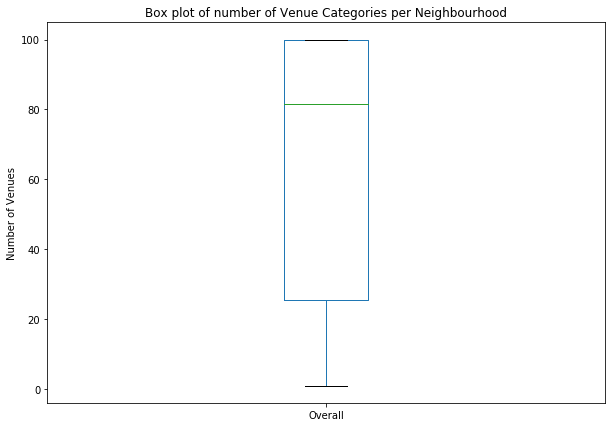

In [49]:
z=all_venues.groupby('Neighbourhood').count().reset_index().sort_values('Venue Category')
z.rename(columns={'Venue Category':'Overall'},inplace=True)
print('Table 4.')
print(z['Overall'].describe())
print('\n\nFigure 3')
z['Overall'].plot(kind='box',figsize=(10,7))
plt.title('Box plot of number of Venue Categories per Neighbourhood')
plt.ylabel('Number of Venues')

#### Clustering Analysis
There are different kinds of methods used for clustering data. Some of these types are partitioning, hierarchical, and density-based clustering. The concept and objective are the same for these different types; however, the steps taken to achieve those objectives are different. Because of these differences, there are pros and cons to using either approach. For instance, a partitioning method of clustering called k-means requires the user to decide the number of clusters to group the data subjectively. On the other hand, the hierarchical approach does not require the user to choose the number of clusters. However, KMeans is generally considered more efficient than the hierarchical approach.
In this report, we use the KMeans clustering method because it's efficient. To avoid the inherent bias in specifying the K number of clusters subjectively, we utilize the 'elbow method' to find the optimal number of 'k' clusters. The YellowBrick extension of the Scikit-Learn API is employed for this purpose.

#### Optimal K Clusters
One method to choose the optimal number of clusters is the elbow method. The objective of the elbow method is to decrease the distance of elements within a given cluster. The steps of the elbow method are to first run the KMeans algorithm multiple times with varying about of clusters/centroids/ k. Then the distortion score is calculated, which is a measurement of the sum-squared-distance from each point to its respective centroid. As k approaches the sample size, the level of distortion decreases. This relationship between k and distortion isn't a bad thing; however, we do not want that many centroids. Thus, the last step is to select the point on the graph at which the marginal improvement begins to decline significantly (the elbow). Thankfully, the KElbowVisualizer of YellowBrick extension finds this point automatedly.

## Results

In the graph below, we can see that the KMeans algorithm was executed 30 times, and the elbow is located where k=14. Therefore, we proceed with 14 as the optimal number of clusters to model the data. 

Figure 4.


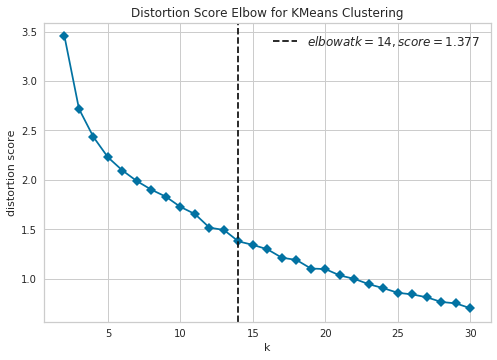

In [53]:
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.font_manager
# Instantiate the clustering model and visualizer
model = KMeans(n_init=10,random_state=False)
visualizer = KElbowVisualizer(model, k=(2,31),timings=False)

visualizer.fit(clustering)        # Fit the data to the visualizer
print('Figure 4.')
visualizer.show()        # Finalize and render the figure

#### KMeans clustering
Using the KMeans approach with 14 centroids, the clusters depicted on the maps in Figures 5 & 6 were generated. Note the following:
* The colors indicate neighbourhoods in the same cluster. For example, two neighbourhoods colored purple are a part of the same cluster.
* Neighbourhoods on two different maps are still a part of the same cluster if they are the same color. For example, Greenwich Village in Manhattan is of the same cluster as North Toronto West in Toronto.
* Table 5 below shows a sample of 4 neighbourhoods in cluster 1 and the top 5 venues categories of each Neighbourhood.  

In [73]:
# create map
map_clusters = folium.Map(location=[t_latitude, t_longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyt_merged['Latitude'], nyt_merged['Longitude'], nyt_merged['Neighbourhood'], nyt_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=16,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
print('Figure 5. Clusters - Toronto Neighbourhoods')       
map_clusters

Figure 5. Clusters - Toronto Neighbourhoods


In [74]:
# create map
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyt_merged['Latitude'], nyt_merged['Longitude'], nyt_merged['Neighbourhood'], nyt_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
print('Figure 6. Clusters - Manhattan Neighbourhoods')            
map_clusters

Figure 6. Clusters - Manhattan Neighbourhoods


In [63]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = onehot_group['Neighbourhood']

for ind in np.arange(onehot_group.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(onehot_group.iloc[ind, :], num_top_venues)
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighbourhoods_venues_sorted.head()

nyt_merged = nyt_df
nyt_merged = nyt_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
print("Table 5.")
nyt_merged.head().sort_values('Cluster Labels')

Table 5.


,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
100,Manhattan,Chinatown,40.715618,-73.994279,1,Chinese Restaurant,Cocktail Bar,Bakery,American Restaurant,Optical Shop
101,Manhattan,Washington Heights,40.851903,-73.936900,1,Café,Mobile Phone Shop,Bakery,Mexican Restaurant,Grocery Store
102,Manhattan,Inwood,40.867684,-73.921210,1,Café,Mexican Restaurant,Deli / Bodega,Pizza Place,Lounge
103,Manhattan,Hamilton Heights,40.823604,-73.949688,1,Café,Mexican Restaurant,Pizza Place,Coffee Shop,Deli / Bodega
6,Manhattan,Marble Hill,40.876551,-73.910660,5,Sandwich Place,Coffee Shop,Miscellaneous Shop,Steakhouse,Supplement Shop


## Discussion

### Recommendation
We now go back to the initial question, "Which neighbourhoods in Toronto are similar to those neighbourhoods of potential immigrants from Manhattan?" Table 4 lists the 14 clusters and the total number of neighbourhoods in each cluster based on their origin (Manhattan or Toronto). Note that only Cluster 1, 5, and 6 hold neighbourhoods from both Manhattan and Toronto. The remaining clusters are made up of only Toronto neighbourhoods. Those clusters are not useful to us. Moving forward, we shall only focus on elements included in those clusters. With that said, Tables 5, 6, and 7 display the neighbourhoods in clusters 1,5 and 6, respectively. These are Manhattan and Toronto neighbourhoods that are like each other. My recommendation is to market homes in neighbourhoods of Toronto to individuals migrating from neighbourhoods in Manhattan located within the same cluster. The logic is that those neighbourhoods would be more compatible with those migrants based on the idea that the venues in the neighbourhoods match their former neighbourhoods in Manhattan. For example, if a new immigrant is from Marble Hill, Manhattan, he or she would probably be keen on Toronto's Davisville or King/Adelaide/Richmond neighbourhoods considering that they're both in Cluster 5 and have similar venues. The same can be said about those moving from Chinatown in Manhattan, which is in Cluster 1 along with the Kensington/Grange Town/Chinatown. These clusters may be very useful in narrowing down neighbourhoods matching the perspective buyers.

Table 6.

| Clusters      | # Manhattan Neighbourhoods          | # Toronto Neighbourhoods  |
| ----------- |:------------------:| ------------------------:|
| 0  | 0| 1|
| 1  |12| 4|
| 2  | 0| 1|
| 3  | 0| 1|
| 4  | 0| 1|
| 5  | 4|19|
| 6  |24| 4|
| 7  | 0| 1|
| 8  | 0| 1|
| 9  | 0| 1|
| 10 | 0| 1|
| 11 | 0| 1|
| 12 | 0| 1|
| 13 | 0| 1|

In [68]:
print("Table 7. Cluster 1")
nyt_merged.loc[nyt_merged['Cluster Labels'] == 1, nyt_merged.columns[[4]+[0] + [1] + list(range(5, nyt_merged.shape[1]))]]

Table 7. Cluster 1


,Cluster Labels,Borough,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
100,1,Manhattan,Chinatown,Chinese Restaurant,Cocktail Bar,Bakery,American Restaurant,Optical Shop
101,1,Manhattan,Washington Heights,Café,Mobile Phone Shop,Bakery,Mexican Restaurant,Grocery Store
102,1,Manhattan,Inwood,Café,Mexican Restaurant,Deli / Bodega,Pizza Place,Lounge
103,1,Manhattan,Hamilton Heights,Café,Mexican Restaurant,Pizza Place,Coffee Shop,Deli / Bodega
104,1,Manhattan,Manhattanville,Coffee Shop,Mexican Restaurant,Chinese Restaurant,Italian Restaurant,Park
106,1,Manhattan,East Harlem,Mexican Restaurant,Bakery,Deli / Bodega,Pizza Place,Latin American Restaurant
118,1,Manhattan,East Village,Bar,Wine Bar,Ice Cream Shop,Mexican Restaurant,Pizza Place
119,1,Manhattan,Lower East Side,Pizza Place,Café,Coffee Shop,Sandwich Place,Japanese Restaurant
124,1,Manhattan,Manhattan Valley,Indian Restaurant,Coffee Shop,Pizza Place,Szechuan Restaurant,Bar
126,1,Manhattan,Gramercy,Bar,Mexican Restaurant,Italian Restaurant,American Restaurant,Pizza Place


In [69]:
print("Table 8. Cluster 5")
nyt_merged.loc[nyt_merged['Cluster Labels'] == 5, nyt_merged.columns[[4]+[0] + [1] + list(range(5, nyt_merged.shape[1]))]]

Table 8. Cluster 5


,Cluster Labels,Borough,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,5,Manhattan,Marble Hill,Sandwich Place,Coffee Shop,Miscellaneous Shop,Steakhouse,Supplement Shop
110,5,Manhattan,Roosevelt Island,Coffee Shop,Sandwich Place,Outdoors & Recreation,Greek Restaurant,Restaurant
125,5,Manhattan,Morningside Heights,Coffee Shop,Park,Bookstore,American Restaurant,Burger Joint
128,5,Manhattan,Financial District,Coffee Shop,Pizza Place,Wine Shop,Hotel,Gym
349,5,East Toronto,Studio District,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant
353,5,Central Toronto,Davisville,Sandwich Place,Pizza Place,Dessert Shop,Italian Restaurant,Coffee Shop
357,5,Downtown Toronto,"Cabbagetown,St. James Town",Restaurant,Café,Coffee Shop,Park,Italian Restaurant
358,5,Downtown Toronto,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant
359,5,Downtown Toronto,"Regent Park,Harbourfront",Coffee Shop,Café,Pub,Park,Bakery
360,5,Downtown Toronto,"Ryerson,Garden District",Coffee Shop,Clothing Store,Cosmetics Shop,Café,Fast Food Restaurant


In [70]:
print("Table 9. Cluster 6")
nyt_merged.loc[nyt_merged['Cluster Labels'] == 6, nyt_merged.columns[[4]+[0] + [1] + list(range(5, nyt_merged.shape[1]))]]

Table 9. Cluster 6


,Cluster Labels,Borough,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
105,6,Manhattan,Central Harlem,American Restaurant,French Restaurant,Chinese Restaurant,Art Gallery,Bar
107,6,Manhattan,Upper East Side,Exhibit,Italian Restaurant,Bakery,Art Gallery,Juice Bar
108,6,Manhattan,Yorkville,Italian Restaurant,Gym,Coffee Shop,Bar,Pizza Place
109,6,Manhattan,Lenox Hill,Coffee Shop,Italian Restaurant,Pizza Place,Sushi Restaurant,Cosmetics Shop
111,6,Manhattan,Upper West Side,Italian Restaurant,Coffee Shop,Wine Bar,Bar,Indian Restaurant
112,6,Manhattan,Lincoln Square,Theater,Italian Restaurant,Gym / Fitness Center,Café,Plaza
113,6,Manhattan,Clinton,Theater,Gym / Fitness Center,Italian Restaurant,Spa,American Restaurant
114,6,Manhattan,Midtown,Hotel,Steakhouse,Coffee Shop,Theater,Clothing Store
115,6,Manhattan,Murray Hill,Coffee Shop,Hotel,Sandwich Place,Japanese Restaurant,Italian Restaurant
116,6,Manhattan,Chelsea,Coffee Shop,Ice Cream Shop,Bakery,Italian Restaurant,Nightclub


### Limitation / Future Opportunity
There are a few limitations to this report; however, these limitations present an opportunity for further research in the area.
* The assumption here is that people migrating from Manhattan to Toronto would like to live in a neighbourhood like the one they are leaving. It can also be true that they want to live in a new neighbourhood, considering that they are moving to a new city.
 * Real estate agents may resolve this by first asking their clients whether they want to live in a neighbourhood like the ones they are leaving. If the answer is 'yes', then the results from this report would help narrow that search down.
 * Also, further survey research can be done to assess what factors most influence immigrants' preference regarding were to Toronto would like to live.
* Elements of the sample representing neighbourhoods in Toronto grouped neighbourhoods based on zip code. For example, Kensington Market, Grange Park, and Chinatown are all treated as one neighbourhood into the dataset; although, there may be some differences between Kensington Market and Chinatown.
 * Further research may be done to consider whether there's any material difference in the results of this report if neighbourhoods in Toronto are not grouped based on zip code.
* KMeans was used to create the clusters in the data. 
 * Further research could be done to consider whether there's any material difference in the results of this report if other clustering methods were used, such as hierarchical clustering and DBSCAN.

## Conclusion

In this report, we analyzed the similarities between neighbourhoods in Manhattan and Toronto based on the types of venues found in those neighbourhoods. This was done using locational data provided Foursquare, which included the venue's categories and their coordinates. We identified 14 clusters in which neighbourhoods in Manhattan and Toronto can be grouped by using the KMeans approach. Manhattan neighbourhoods fit into three clusters, and within those clusters, there were neighbourhoods in Toronto that were also included. Those neighbourhoods in Toronto match the respective neighbourhoods in Manhattan. This information can be useful in helping real estate agents select the most suitable Neighbourhood for clients immigrating from Manhattan to Toronto.

# References

[1] https://www.canada.ca/en/immigration-refugees-citizenship/corporate/publications-manuals/annual-report-parliament-immigration-2018/permanent-residents-admitted.html

[2] https://www.canada.ca/en/immigration-refugees-citizenship/corporate/publications-manuals/annual-report-parliament-immigration-2018/report.html

[3] https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

[4] https://geo.nyu.edu/catalog/nyu_2451_34572

[5] https://developer.foursquare.com/